# Setup with Conda
First install the libmamba solver for Conda
```sh
    conda update -n base conda
    conda install -n base conda-libmamba-solver
    conda config --set solver libmamba
```

Next create a new Conda Environment with the instances
```sh
    conda create --solver=libmamba -n rapids-23.10 -c rapidsai -c conda-forge -c nvidia  \
    rapids=23.10 python=3.10 cuda-version=12.0
```

Finally install pip
```sh
    conda install pip
```

Use pip to install any other missing packages/modules for this notebook

In [1]:
!pip install facenet_pytorch
!pip install keras_facenet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.7 MB/s eta 0:00:00
  Created wheel for keras_facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=6732b74b8419eb61953abeac588b718c53c73191b207f2e7624841249f240a36
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras_facenet


In [5]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 413, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 413 (delta 103), reused 58 (delta 54), pack-reused 269
Receiving objects: 100% (413/413), 113.29 KiB | 1.14 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [ ]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import os
from os import listdir
from numpy import load
from numpy import asarray
from numpy import savez_compressed
from sklearn.preprocessing import StandardScaler as StandardScaler_C
from sklearn.preprocessing import MinMaxScaler as MinMaxScaler_C
from sklearn.neighbors import KNeighborsClassifier as KNeighborsClassifier_C
from sklearn.preprocessing import LabelEncoder as LabelEncoder_C
from sklearn import metrics as metrics_C
from sklearn.cluster import KMeans as KMeans_C
# from keras.models import load_model
from keras_facenet import FaceNet
# from mtcnn.mtcnn import MTCNN
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import Normalizer
# from sklearn.metrics import accuracy_score
# from cuml import KMeans
from cuml.cluster import KMeans
from cuml.metrics.accuracy import accuracy_score
#from cuml.dask.preprocessing.LabelEncoder import LabelEncoder
from cuml.preprocessing import LabelEncoder
from cuml.svm import LinearSVC
from cuml.preprocessing import Normalizer
import cudf
import cupy as cp
import pandas as pd
import re

USE_CUDA = True

if (USE_CUDA):
    device = 'cuda:0'
else:
    device = 'cpu'

In [ ]:
# extracts faces from entire LFW dataset using MTCNN
''' preprocessing_file = '../mtcnn_extracted_faces/'
from_file = '../LFW_Dataset/lfw-deepfunneled/lfw-deepfunneled/' '''
mtcnn = MTCNN(post_process=False, device=device)
preprocessing_file = './mtcnn_extracted_faces/'
from_file = './lfw-deepfunneled/'


list_directories = os.listdir(from_file)
for dir in list_directories:
  save_path = preprocessing_file + dir + '/'
  if not os.path.exists(save_path):
    os.makedirs(save_path)

  curr_path = from_file + dir
  curr_files = [curr_path + '/' + image for image in os.listdir(curr_path)]
  for i, curr_img in enumerate(curr_files):
    frame = Image.open(curr_img).convert("RGB")
    face = mtcnn(frame)

    if face is None:
      continue
    img=Image.fromarray(np.uint8(face.permute(1,2,0).int().numpy()))
    save_name = save_path + dir + str(i).zfill(4) + '.jpg'
    img.save(save_name)

In [ ]:
def load_dataset(directory, batch_size=1000):
  train_x, train_y, test_x, test_y = [],[], [],[]
  batch_num = 0

  # add slash to end of dir path
  if directory[-1] != '/':
    directory += '/'

  for i, subdir in enumerate(listdir(directory)):

    if ((i % batch_size) == 0) and i != 0:
      savez_compressed('lfw-deepfunneled-dataset_{}.npz'.format(str(batch_num).zfill(4)),train_x,train_y,test_x,test_y)

      train_x, train_y, test_x, test_y = [],[], [],[]
      batch_num += 1

    path = directory + subdir + '/'
    #load all faces in subdirectory
    faces = [asarray(Image.open(path + img_name).convert("RGB")) for img_name in listdir(path)]
    if len(faces)>1:
      test_x.append(faces.pop())
      test_y.append(subdir)
    labels = [subdir for _ in range(len(faces))]
    # print("%d There are %d images in the class %s:"%(i,len(faces),subdir))
    train_x.extend(faces)
    train_y.extend(labels)
  # return asarray(train_x),asarray(train_y), asarray(test_x), asarray(test_y)

  if not (train_x == [] and train_y == [] and test_x == [] and test_y == []):
    savez_compressed('lfw-deepfunneled-dataset_{}.npz'.format(str(batch_num).zfill(4)),train_x,train_y,test_x,test_y)


load_dataset('./mtcnn_extracted_faces/')

In [ ]:
#create and save embeddings
embedder = FaceNet()
#load the compressed dataset and facenet keras model
dataset_npz_filenames = []
reg_expr = '^lfw-deepfunneled-dataset_[0-9]{4}.npz'
for file in listdir('./'):
    if re.search(reg_expr, file):
        dataset_npz_filenames.append(file)

print(dataset_npz_filenames)
new_trainy, new_testy  = [], []
new_trainx = new_testx = np.zeros((0,512), dtype='float32')
for i, file in enumerate(dataset_npz_filenames):
    data = load(file)
    trainx, trainy, testx, testy = data['arr_0'], data['arr_1'], data['arr_2'],  data['arr_3']
    print(trainx.shape,trainy.shape,testx.shape, testy.shape)

    new_trainx = np.vstack((new_trainx, embedder.embeddings(trainx)))
    new_testx = np.vstack((new_testx, embedder.embeddings(testx)))
    print('new_trainx {} | new_testx {} | dtype {}'.format(new_trainx.shape, new_testx.shape, new_testx.dtype))

    for el in trainy:
        new_trainy.append(el)
    for el in testy:
        new_testy.append(el)
    print('new_trainy {} | new_testy {} '.format(len(new_trainy), len(new_testy)))

new_trainy=np.array(new_trainy)
new_testy=np.array(new_testy)

#save the embeddings
#compress the 512 embeddings of each face
print("Final new_trainx size {} | Final new_testx size {}".format(new_trainx.shape, new_testx.shape))
print("Final new_trainy size {} | Final new_testy size {}".format(new_trainy.shape, new_testy.shape))
savez_compressed('lfw-deepfunneled-embeddings.npz',new_trainx,new_trainy,new_testx,new_testy)

['lfw-deepfunneled-dataset_0002.npz', 'lfw-deepfunneled-dataset_0005.npz', 'lfw-deepfunneled-dataset_0001.npz', 'lfw-deepfunneled-dataset_0004.npz', 'lfw-deepfunneled-dataset_0003.npz', 'lfw-deepfunneled-dataset_0000.npz']
(1798, 160, 160, 3) (1798,) (304, 160, 160, 3) (304,)
10/10 [==============================] - 0s 35ms/step
new_trainx (1798, 512) | new_testx (304, 512) | dtype float32
new_trainy 1798 | new_testy 304 
(1219, 160, 160, 3) (1219,) (204, 160, 160, 3) (204,)
7/7 [==============================] - 0s 35ms/step
new_trainx (3017, 512) | new_testx (508, 512) | dtype float32
new_trainy 3017 | new_testy 508 
(1903, 160, 160, 3) (1903,) (302, 160, 160, 3) (302,)
10/10 [==============================] - 0s 36ms/step
new_trainx (4920, 512) | new_testx (810, 512) | dtype float32
new_trainy 4920 | new_testy 810 
(2028, 160, 160, 3) (2028,) (296, 160, 160, 3) (296,)
10/10 [==============================] - 0s 36ms/step
new_trainx (6948, 512) | new_testx (1106, 512) | dtype float32

In [ ]:
# Load the compressed dataset and embeddings
data = np.load('./lfw-deepfunneled-embeddings.npz')
train_X, train_Y, test_X, test_Y = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']


In [ ]:
#Linear SVC Results

model=LinearSVC(C=10)

#MinMaxScaling
scaler=MinMaxScaler_C().fit(train_X)
trainx =scaler.transform(train_X)
testx = scaler.transform(test_X)

#encode labels
label_encoder = LabelEncoder().fit(train_Y)
true_training_labels_encoded = label_encoder.transform(train_Y)

model.fit(cp.asarray(trainx),cp.asarray(true_training_labels_encoded))


#predict
predict_train = model.predict(cp.asarray(trainx))
predict_test = model.predict(cp.asarray(testx))

#Accuracy
true_test_labels_encoded = label_encoder.transform(test_Y)
acc_train = accuracy_score(true_training_labels_encoded,predict_train)
acc_test = accuracy_score(true_test_labels_encoded,predict_test)



print(acc_train)
print(acc_test)


0.9962780475616455
0.8439547419548035


' #display\ntrainy_list = list(trainy)\nselected_idx=0\np=int(predict_train[selected_idx])\n\n# if p in trainy_list:\nval = trainy_list.index(p)\n\n#display Predicated data\nplt.subplot(1,2,2)\nplt.imshow(train_x[val])\nplt.title(train_y[val])\nplt.xlabel("Predicted Data")\n\n#print(train_y) '

In [ ]:
#KNN-CPU

#Scaling
scaler=MinMaxScaler_C().fit(train_X)
trainx =scaler.transform(train_X)
testx = scaler.transform(test_X)

#encode labels
label_encoder = LabelEncoder_C().fit(train_Y)
true_training_labels_encoded = label_encoder.transform(train_Y)
true_test_labels_encoded = label_encoder.transform(test_Y)

#draw graph
N=trainx.shape[0]
k = 1
neigh = KNeighborsClassifier_C(n_neighbors = k).fit(trainx,true_training_labels_encoded)
predict_train = neigh.predict(trainx)
predict_test = neigh.predict(testx)
print("Accuracy of model at for training is",metrics_C.accuracy_score(true_training_labels_encoded, predict_train))
print("Accuracy of model at for testing is",metrics_C.accuracy_score(true_test_labels_encoded, predict_test))


Accuracy of model at for training is 1.0
Accuracy of model at for testing is 0.8826682549136391


In [ ]:
!unzip GallagherDataset.zip

In [ ]:
#Unsupervised learning
#may need to change imports to use rapids



from sklearn.model_selection import train_test_split as train_test_split_C



mtcnn = MTCNN(keep_all=True,post_process=False, device='cpu')
preprocessing_folder = './galla_mtcnn_extracted_faces/'
from_folder= './GallagherDataset/'


images = sorted(os.listdir(from_folder))
for curr_img in images:
  frame = Image.open(from_folder+curr_img).convert("RGB")
  faces = mtcnn(frame)

  if faces is None:
    continue

  save_path = preprocessing_folder + curr_img + '/'
  if not os.path.exists(save_path):
    os.makedirs(save_path)
  for i,face in enumerate(faces):
    img=Image.fromarray(np.uint8(face.permute(1,2,0).int().numpy()))
    save_name = save_path + curr_img + str(i).zfill(4) + '.jpg'
    img.save(save_name)




In [51]:
images_lookup=[] #save thiis
from sklearn.model_selection import train_test_split as train_test_split_C #use gpu instead
def load_unlabelled_dataset(directory): #we store mapping and do not bundle sincee maxsize=500. Ideally should bundle and save to file
  embedder = FaceNet()

  # add slash to end of dir path
  if directory[-1] != '/':
    directory += '/'

  all_faces=[]
  for i, subdir in enumerate(sorted(listdir(directory))):
    path = directory + subdir + '/'
    #load all faces in subdirectory
    faces = [asarray(Image.open(path + img_name).convert("RGB")) for img_name in listdir(path)]
    all_faces.extend(faces)
    for face in range(len(faces)):
      images_lookup.append(subdir)

  all_faces=np.array(all_faces)
  # print(all_faces[:5])
  x_train = embedder.embeddings(all_faces)
  #x_train,x_test=train_test_split_C(embeddings,test_size=0.30,random_state=77) do for lfw instead
  savez_compressed('GallagherDataset-embeddings.npz',x_train)


load_unlabelled_dataset('./galla_mtcnn_extracted_faces/')

61/61 [==============================] - 73s 1s/step


In [108]:
#Clustering - different dataset
# Apply k-means clustering
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score
data = np.load('./GallagherDataset-embeddings.npz')
train_X = data['arr_0']


#MinMaxScaling
scaler=MinMaxScaler_C().fit(train_X)
trainx =scaler.transform(train_X)

''' scaler=StandardScaler_C().fit(train_X)
trainx =scaler.transform(train_X) '''


''' scaler=Normalizer(norm='l2')
trainx =scaler.transform(train_X)  '''


#use elbow method
k = 32
kmeans = KMeans_C(n_clusters=k, random_state=5)
''' kmeans.fit(cudf.DataFrame(train_X)) '''
kmeans.fit(train_X)


''' with np.printoptions(threshold=np.inf):
    print("labels:")
    print(kmeans.labels_)
    print("cluster_centers:")
    print(kmeans.cluster_centers_) '''

# Predict clusters on the test set
''' test_clusters = kmeans.predict(test_X) '''

# Evaluate clustering performance
print(f'Clustering Inertia: {kmeans.inertia_}')
print(f'Clustering Silhouette score: {silhouette_score(train_X,kmeans.labels_)}')


#form groups of results (map or union find? datastructure)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clustering Inertia: 777.4534301757812
Clustering Silhouette score: 0.07565965503454208


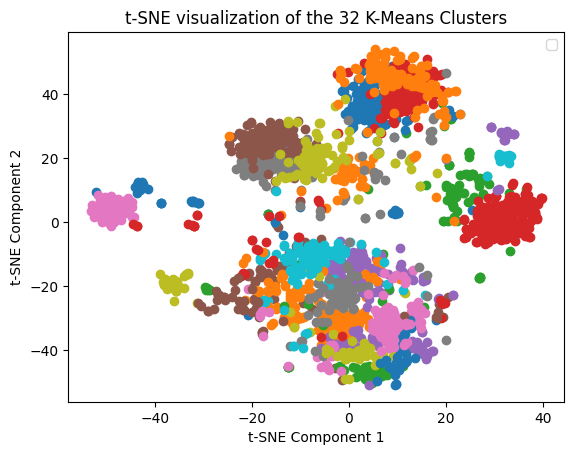

In [62]:
from sklearn.manifold import TSNE
def kMeansDisplay():

  X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(train_X)

  k_result = kmeans.predict(train_X)

  # Obtain all clusters which are unique
  k_clusters = np.unique(k_result)

  # plot clusters
  for i,k_cluster in enumerate(k_clusters):
      # fetch data point that fall in this clstr
      index = np.where(k_result == k_cluster)

      plt.scatter(X_embedded[index, 0], X_embedded[index,1])


  # Agglomerative hierarchy plot
  plt.title('t-SNE visualization of the 32 K-Means Clusters')
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')
  plt.legend()
  plt.show()

kMeansDisplay()



In [ ]:
#given an image
def kMeansPredict(image):

  #load model
  #load scaling

  #face detection
  mtcnn = MTCNN(keep_all=True,post_process=False, device='cpu')
  faces = mtcnn(image)

  if faces is None:
    return None

  all_faces=[]
  for face in faces:
    img=face.permute(1,2,0).int().numpy()
    display(Image.fromarray(np.uint8(img)))
    all_faces.append(img)

  embedder = FaceNet()
  found_embeddings_arr=[]
  for j,face in enumerate(all_faces):
    #get embeddings
    face=np.array([face])
    embed = embedder.embeddings(face)
    if embed is None:
      continue
    #predict on embeddings
    embed = scaler.transform(embed)
    test_cluster=kmeans.predict(embed) #what if multiple faces??
    found_embeddings_idx=set()
    for i,cluster in enumerate(kmeans.labels_):
      if cluster==test_cluster:
        found_embeddings_idx.add(i)
    found_embeddings_arr.append(found_embeddings_idx)

    #found_embeddings_idx=found_embeddings_idx & curr_embeddings_idx if j>0 else found_embeddings_idx | curr_embeddings_idx
  #print("curr ",found_embeddings_arr)
  imgs_filenames=set()
  for j,found_embeddings_idx in enumerate(found_embeddings_arr):
    curr_files=set()
    for i in found_embeddings_idx:
      curr_files.add(images_lookup[i])
    imgs_filenames=imgs_filenames & curr_files if j>0 else imgs_filenames | curr_files


  return set(imgs_filenames)

  #return all images
#filename='./GallagherDataset/100_1803.JPG'
#filename='./GallagherDataset/100_1737.JPG'
#filename='./GallagherDataset/100_1739.JPG'
filename='./GallagherDataset/100_1757.JPG'
#filename='./GallagherDataset/100_1803.JPG'
#filename='./GallagherDataset/100_1816.JPG'

img=Image.open(filename).convert("RGB")
display(img)
res_filenames=kMeansPredict(img)
folder='./GallagherDataset/'
for filename in res_filenames:
  display(Image.open(folder+filename))



In [ ]:
!tar -xvzf galla_mtcnn_extracted_faces.tar.gz

In [ ]:
!unzip GallagherDataset.zip

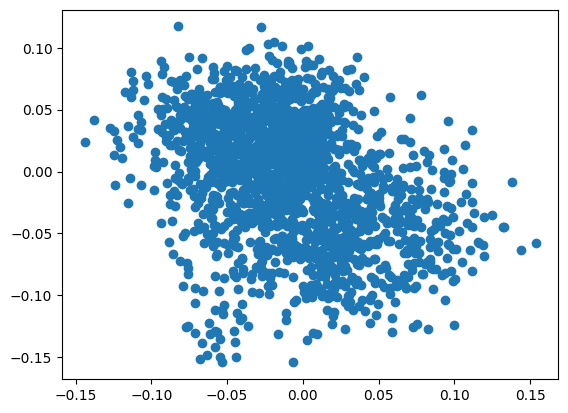

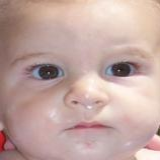

1/1 [==============================] - 2s 2s/step
[-1 -1 -1 ... -1 -1 -1]


In [54]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plot

def dbscanPredict(image):
  # Define model
  dbscan_model = DBSCAN(eps=0.25, min_samples=25)

  # Train the model
  dbscan_model.fit(train_X)

  # Assign each data point to a cluster
  dbscan_res = dbscan_model.fit_predict(train_X)

  # obtain all the unique clusters
  dbscan_clstrs = np.unique(dbscan_res)

  # Plot the DBSCAN clusters
  for dbscan_clstr in dbscan_clstrs:
      # Obtain data point that belong in this cluster
      index = np.where(dbscan_res == dbscan_clstr)
      # plot
      plot.scatter(train_X[index, 0], train_X[index, 1])

  # show plot
  plot.show()


  mtcnn = MTCNN(keep_all=True,post_process=False, device='cpu')
  faces = mtcnn(image)

  if faces is None:
    return None

  all_faces=[]
  for face in faces:
    img=face.permute(1,2,0).int().numpy()
    display(Image.fromarray(np.uint8(img)))
    all_faces.append(img)
  all_faces=np.array(all_faces)

  #get embeddings
  embedder = FaceNet()
  embeddings = embedder.embeddings(all_faces)

  #predict on embeddings
  embeddings = scaler.transform(embeddings)
  test_cluster=dbscan_model.fit_predict(np.vstack((embeddings,train_X)))[0] #what if multiple faces??

  found_embeddings_idx=[]
  for i,cluster in enumerate(dbscan_model.labels_[1:]):
    if cluster==test_cluster:
      found_embeddings_idx.append(i-1)
  print(dbscan_model.labels_)
  imgs_filenames=[]
  for i in found_embeddings_idx:
    #print(i)
    imgs_filenames.append(images_lookup[i])
  return set(imgs_filenames)

filename='./galla_mtcnn_extracted_faces/100_1720.JPG/100_1720.JPG0000.jpg'
img=Image.open(filename).convert("RGB")
s=dbscanPredict(img)





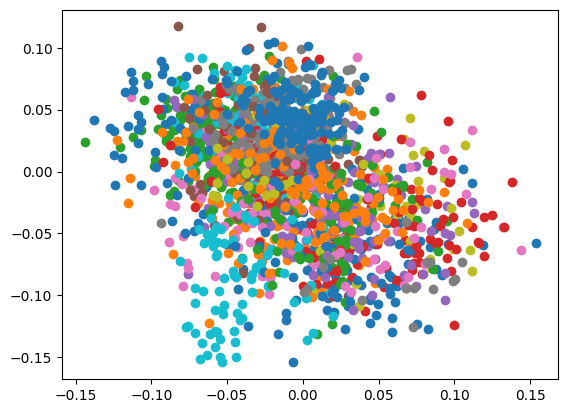

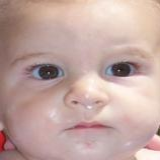

1/1 [==============================] - 2s 2s/step
23
[23 16  9 ...  9 11 30]
set()


In [55]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plot

def aggPredict(image):

  agg_mdl = AgglomerativeClustering(n_clusters=32)

  # each data point assigned to cluster
  agg_result = agg_mdl.fit_predict(train_X)

  # Obtain all clusters which are unique
  agg_clusters = np.unique(agg_result)

  # plot clusters
  for agg_cluster in agg_clusters:
      # fetch data point that fall in this clstr
      index = np.where(agg_result == agg_cluster)

      plot.scatter(train_X[index, 0], train_X[index,1])

  # Agglomerative hierarchy plot
  plot.show()


  mtcnn = MTCNN(keep_all=True,post_process=False, device='cpu')
  faces = mtcnn(image)

  if faces is None:
    return None

  all_faces=[]
  for face in faces:
    img=face.permute(1,2,0).int().numpy()
    display(Image.fromarray(np.uint8(img)))
    all_faces.append(img)
  all_faces=np.array(all_faces)

  #get embeddings
  embedder = FaceNet()
  embeddings = embedder.embeddings(all_faces)

  #predict on embeddings
  embeddings = scaler.transform(embeddings)
  test_cluster=agg_mdl.fit_predict(np.vstack((embeddings,train_X)))[0] #what if multiple faces??
  print(test_cluster)
  print(agg_mdl.labels_)
  found_embeddings_idx=[]
  for i,cluster in enumerate(agg_mdl.labels_[1:]):
    if cluster==test_cluster:
      found_embeddings_idx.append(i-1)

  imgs_filenames=[]
  for i in found_embeddings_idx:
    #print(i)
    imgs_filenames.append(images_lookup[i])
  return set(imgs_filenames)

filename='./galla_mtcnn_extracted_faces/100_1720.JPG/100_1720.JPG0000.jpg'
img=Image.open(filename).convert("RGB")
print(aggPredict(img))



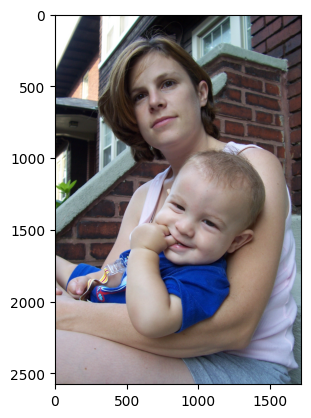

In [26]:

filename='100_1803.JPG'
img=Image.open(filename).convert("RGB")

mtcnn = MTCNN(keep_all=True,post_process=False, device='cpu')
faces = mtcnn(img)

fig,ax=plt.subplots()
#ax.set_title('Residual Visualization')
#ax.set_xlabel('Frame Number');ax.set_ylabel('Residual');
#ax.plot(np.arange(1,rows+1),frame_residual.flatten())
ax.imshow(img)

imgs_=[None,None]
for i,face in enumerate(faces):
  img_=face.permute(1,2,0).int().numpy()
  imgs_[i]=img_
  #display(Image.fromarray(np.uint8(img)))




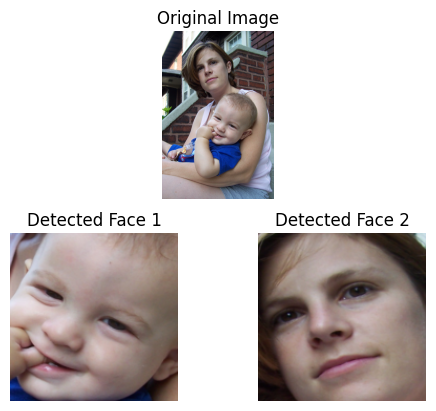

In [39]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0)
ax0 = plt.subplot(gs[0, 1:3])
ax0.imshow(img)
ax0.axis('off')
ax0.set_title('Original Image')
ax1 = plt.subplot(gs[1, :2], )
ax1.imshow(imgs_[0])
ax1.set_title('Detected Face 1')
ax1.axis('off')
ax2 = plt.subplot(gs[1, 2:])
ax2.imshow(imgs_[1])
ax2.set_title('Detected Face 2')
ax2.axis('off')

plt.show()